# Surgery pipeline with TRVAE - comparison between zero-, one-shot and full query training

In [47]:
import scib

In [48]:
import os
import timeit
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [49]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [50]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


### Set relevant anndata.obs labels and training length

In [51]:
condition_key = 'batch'
cell_type_key = 'final_annotation'
target_conditions = ['Oetjen_A','Sun_sample1_CS']

trvae_epochs = 500
alpha_epoch = 200 
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [52]:
url = 'https://figshare.com/ndownloader/files/25717328'
output = 'Immune_ALL_human.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://figshare.com/ndownloader/files/25717328
To: /home/icb/aleksandra.topalova/scarches/Immune_ALL_human.h5ad
100%|██████████| 2.06G/2.06G [00:54<00:00, 37.7MB/s]


'Immune_ALL_human.h5ad'

In [53]:
adata = sc.read('Immune_ALL_human.h5ad')

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: OldFormatWarning: Element '/obs/__categories/batch' was written without encoding metadata.
  categories = read_elem(categories_dset)
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:587: OldFormatWarning: Element '/obs/batch' was written without encoding metadata.
  read_elem(dataset), categories, ordered=ordered
/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/anndata/_io/specs/methods.py:584: 

In [54]:
adata.X = adata.layers["counts"].copy()

In [55]:
adata = adata[~adata.obs[condition_key].isin(['Villani'])]
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_conditions = source_adata.obs[condition_key].unique().tolist()

In [56]:
target_adata.obs['ref_or_query'] = 'query'
source_adata.obs['ref_or_query'] = 'ref'

In [57]:
source_adata

AnnData object with n_obs × n_vars = 28173 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    layers: 'counts'

In [58]:
target_adata

AnnData object with n_obs × n_vars = 4311 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    layers: 'counts'

In [59]:
source_adata.raw = source_adata
sc.pp.normalize_total(source_adata)
sc.pp.log1p(source_adata)

In [60]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [61]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [62]:
source_adata

AnnData object with n_obs × n_vars = 28173 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

### Create TRVAE model and train it on reference dataset

Create the trVAE model instance with NB loss as default. Insert "recon_loss='mse'," or "recon_loss='zinb'," to change the reconstruction loss.

In [63]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 7
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 7
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [64]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=alpha_epoch,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

 |█████---------------| 29.6%  - val_loss: 744.9295820756 - val_recon_loss: 708.1649391868 - val_kl_loss: 16.2783363082 - val_mmd_loss: 24.8000672080
ADJUSTED LR
 |███████-------------| 35.2%  - val_loss: 745.2888433283 - val_recon_loss: 706.8695761941 - val_kl_loss: 15.0154724121 - val_mmd_loss: 25.2807323282
ADJUSTED LR
 |███████-------------| 39.4%  - val_loss: 747.3848100142 - val_recon_loss: 707.0494745428 - val_kl_loss: 14.5621725429 - val_mmd_loss: 26.0644032738
ADJUSTED LR
 |████████------------| 42.4%  - val_loss: 748.2199318626 - val_recon_loss: 707.4085804332 - val_kl_loss: 14.5154105100 - val_mmd_loss: 26.2959378849
ADJUSTED LR
 |████████------------| 43.8%  - val_loss: 746.8482444070 - val_recon_loss: 706.9940629439 - val_kl_loss: 14.5129304366 - val_mmd_loss: 25.3412583958
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of n

### Create anndata file of latent representation and compute UMAP

In [65]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


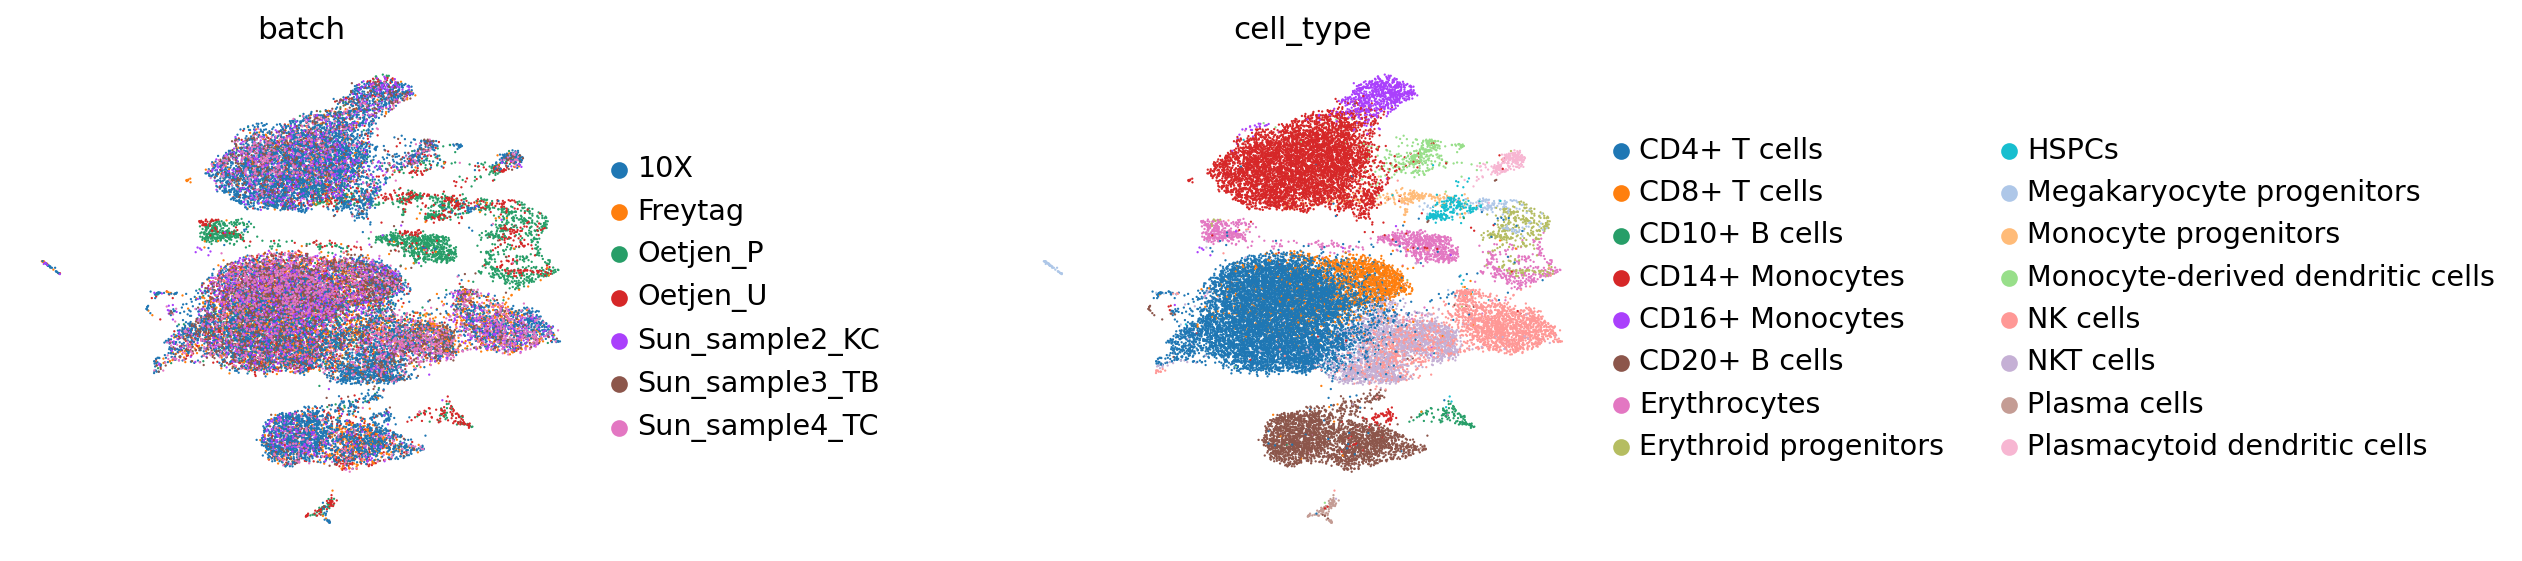

In [66]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

After pretraining the model can be saved for later use

In [67]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [68]:
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query'
    layers: 'counts'

### Perform surgery on reference model and train on query dataset using one-shot mapping

In [69]:
time_one_array = []

for epochs in reversed(range(1,11)):
    start_time_1 = timeit.default_timer()

    query_model_one_1 = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = epochs)

    time_one = timeit.default_timer() - start_time_1
    print(f'Executed in {time_one} seconds') 
    
    if epochs == 10:
        query_model_one = query_model_one_1
        val_loss_1 = query_model_one.trainer.logs['val_loss']
    time_one_array.append(time_one)

AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 7
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 7
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

Device cpu
Processing original category: Oetjen_A n_obs: 2586
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  processing Sun_sample4_TC
Processing original category: Sun_sample1_CS n_obs: 1725
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  

### Perform surgery on reference model and train on query dataset using zero-shot mapping

In [70]:
start_time_0 = timeit.default_timer()

query_model_zero = trvae.one_shot_surgery(target_adata, ref_path, copy=False, pretrain = 0)

time_zero = timeit.default_timer() - start_time_0
print(f'Executed in {time_zero} seconds')

AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 7
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 7
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

Device cpu
Processing original category: Oetjen_A n_obs: 2586
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  processing Sun_sample4_TC
Processing original category: Sun_sample1_CS n_obs: 1725
  processing Oetjen_P
  processing Oetjen_U
  processing Freytag
  processing 10X
  processing Sun_sample2_KC
  processing Sun_sample3_TB
  

### Perform surgery on reference model and train on query dataset using full query training

In [71]:
query_model_full = sca.models.TRVAE.load_query_data(adata=target_adata, reference_model=ref_path)

AnnData object with n_obs × n_vars = 4311 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_or_query', '_original_batch'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 2000 128 9
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 9
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [72]:
start_time_f = timeit.default_timer()

query_model_full.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=alpha_epoch,
    early_stopping_kwargs=early_stopping_kwargs,
    weight_decay=0
)

time_full = timeit.default_timer() - start_time_f
print(f'Executed in {time_full} seconds') 

 |██------------------| 12.2%  - val_loss: 700.0651092529 - val_recon_loss: 694.4692840576 - val_kl_loss: 16.6772875786 - val_mmd_loss: 0.5926365852
ADJUSTED LR
 |████----------------| 20.0%  - val_loss: 692.0847930908 - val_recon_loss: 683.2869873047 - val_kl_loss: 16.5714349747 - val_mmd_loss: 0.5949401855
ADJUSTED LR
 |████----------------| 21.4%  - val_loss: 703.5393981934 - val_recon_loss: 694.0310821533 - val_kl_loss: 16.7832684517 - val_mmd_loss: 0.6132030487
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 85
Executed in 43.55041212029755 seconds


#### Time Benchmarking results

In [73]:
time_zero

9.156234320253134

In [74]:
time_one_array

[15.096013870090246,
 13.298983950167894,
 12.532418183982372,
 12.382647084072232,
 12.034255500882864,
 11.08395560644567,
 10.944775637239218,
 10.764581307768822,
 10.319905143231153,
 9.744605703279376]

In [75]:
time_full

43.55041212029755

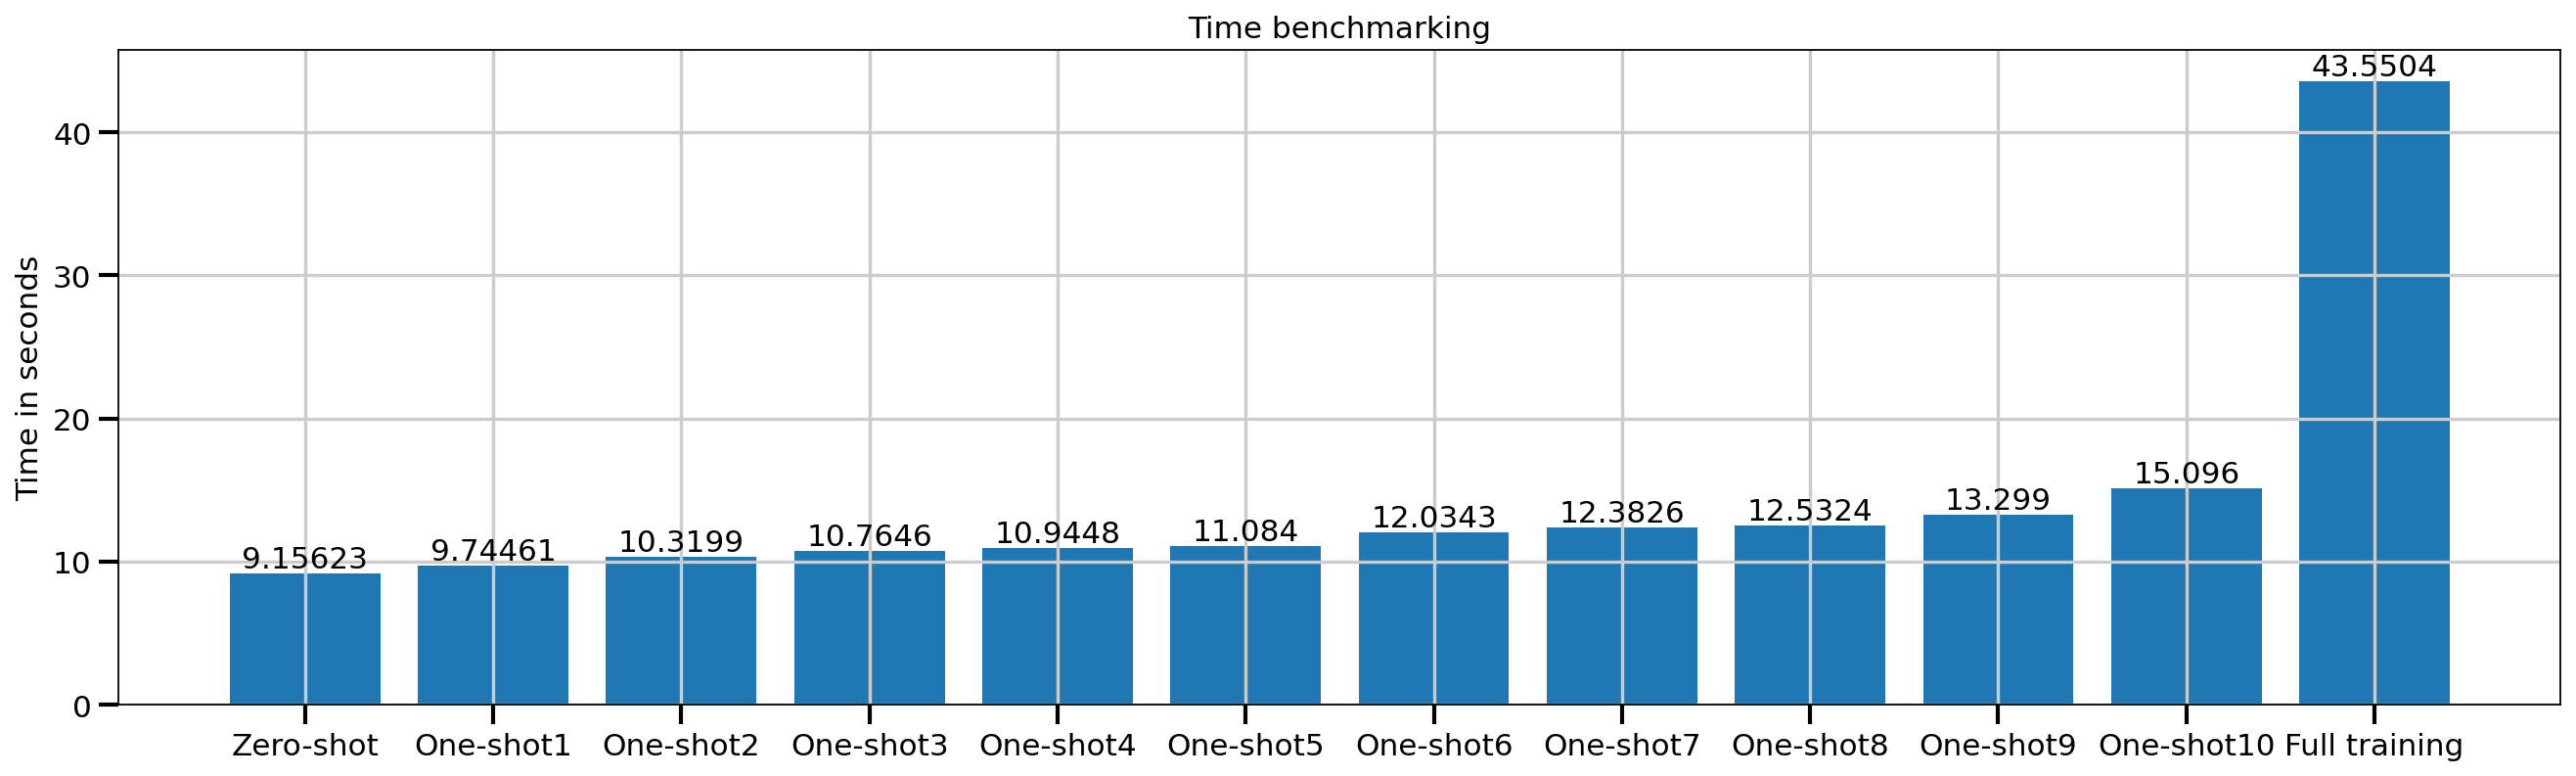

In [76]:
from matplotlib import pyplot as plt

time = time_one_array.copy()
time.reverse()
time.append(time_full)
time.insert(0, time_zero)

x = [f'One-shot{i}' for i in range(1,11)]
x.append('Full training')
x.insert(0, 'Zero-shot')

plt.rcParams["figure.figsize"] = (20,5.5)
bars = plt.bar(x, time)
plt.bar_label(bars)
plt.title('Time benchmarking')
plt.ylabel('Time in seconds')
plt.show()

#### Value loss comparison

In [77]:
val_loss_1 = query_model_one.trainer.logs["val_loss"]
val_loss_full = query_model_full.trainer.logs["val_loss"]

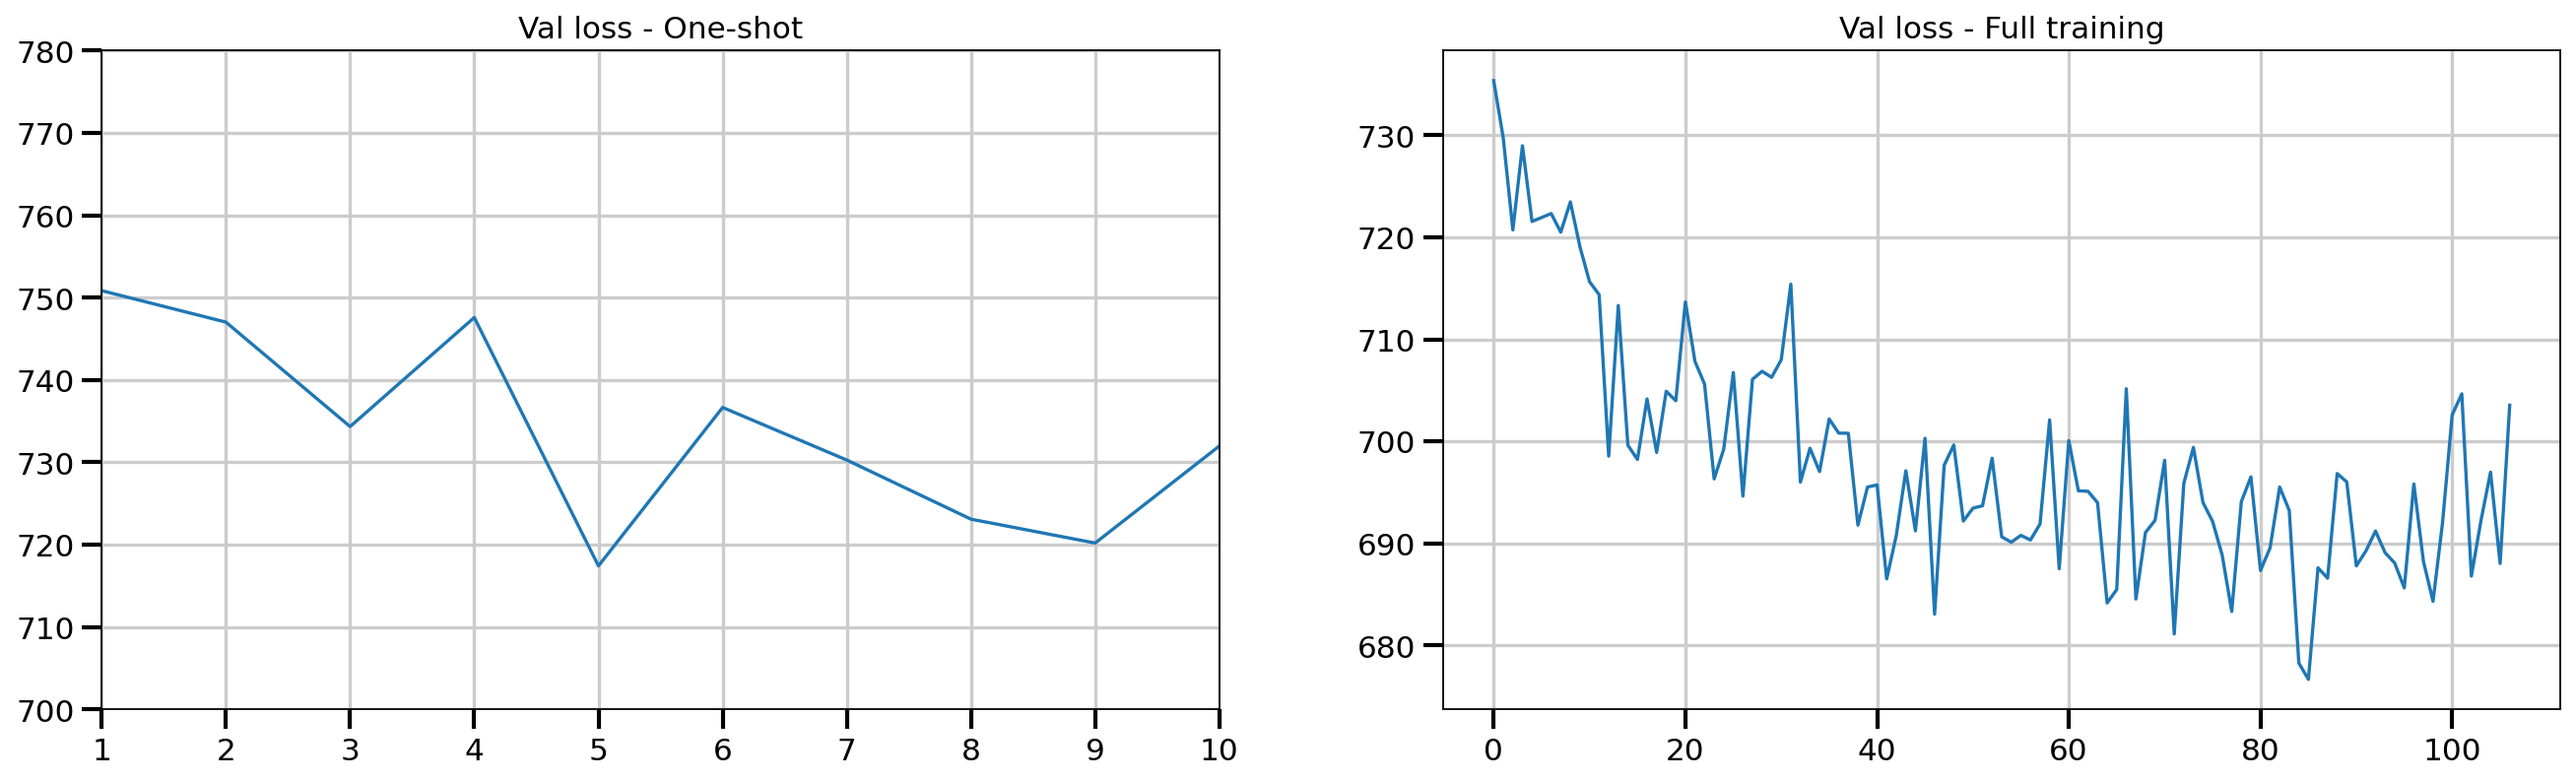

In [78]:

plt.subplot(1, 2, 1)
plt.plot(range(1,11), val_loss_1, label='Val loss')
plt.axis([1, 10, 700, 780])
plt.title('Val loss - One-shot')

plt.subplot(1, 2, 2)
plt.plot(range(len(val_loss_full)), val_loss_full, label='Val Loss')
plt.title('Val loss - Full training')
plt.show()

#### Latent Representations

In [79]:
surg_path = ['query_model_zero', 'query_model_one', 'query_model_full']

In [80]:
adata_latent_array = []
models = [query_model_zero, query_model_one, query_model_full]

In [81]:
for model in models:
    adata_latent = sc.AnnData(model.get_latent())
    adata_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
    adata_latent.obs['batch'] = target_adata.obs[condition_key].tolist()
    adata_latent_array.append(adata_latent)

In [82]:
adata_latent_array

[AnnData object with n_obs × n_vars = 4311 × 10
     obs: 'cell_type', 'batch',
 AnnData object with n_obs × n_vars = 4311 × 10
     obs: 'cell_type', 'batch',
 AnnData object with n_obs × n_vars = 4311 × 10
     obs: 'cell_type', 'batch']

In [83]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


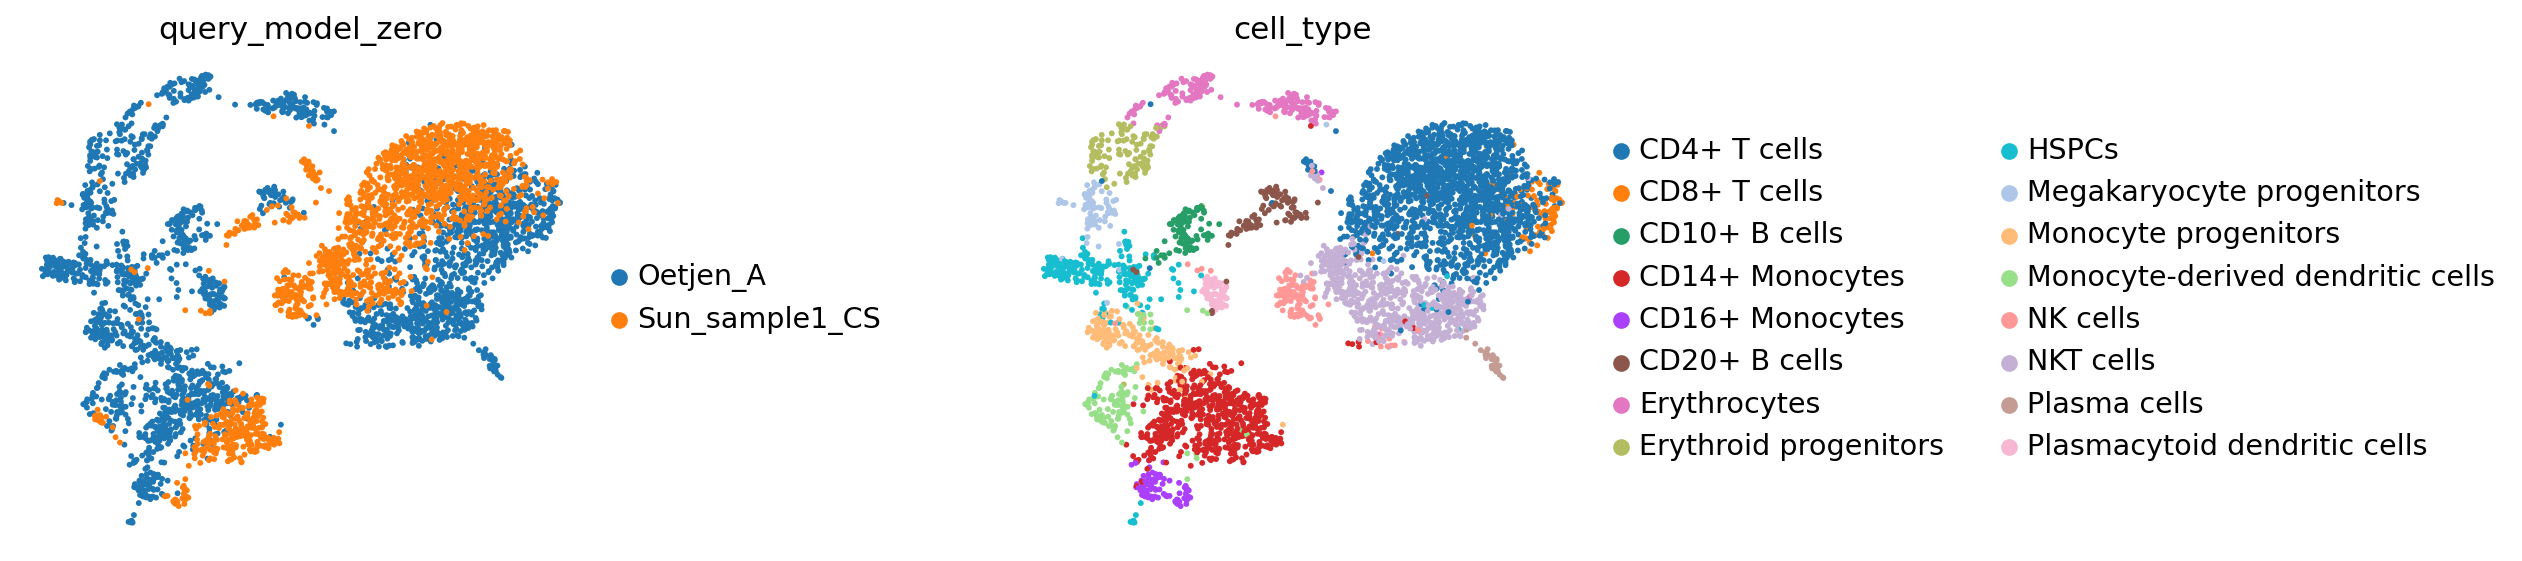

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


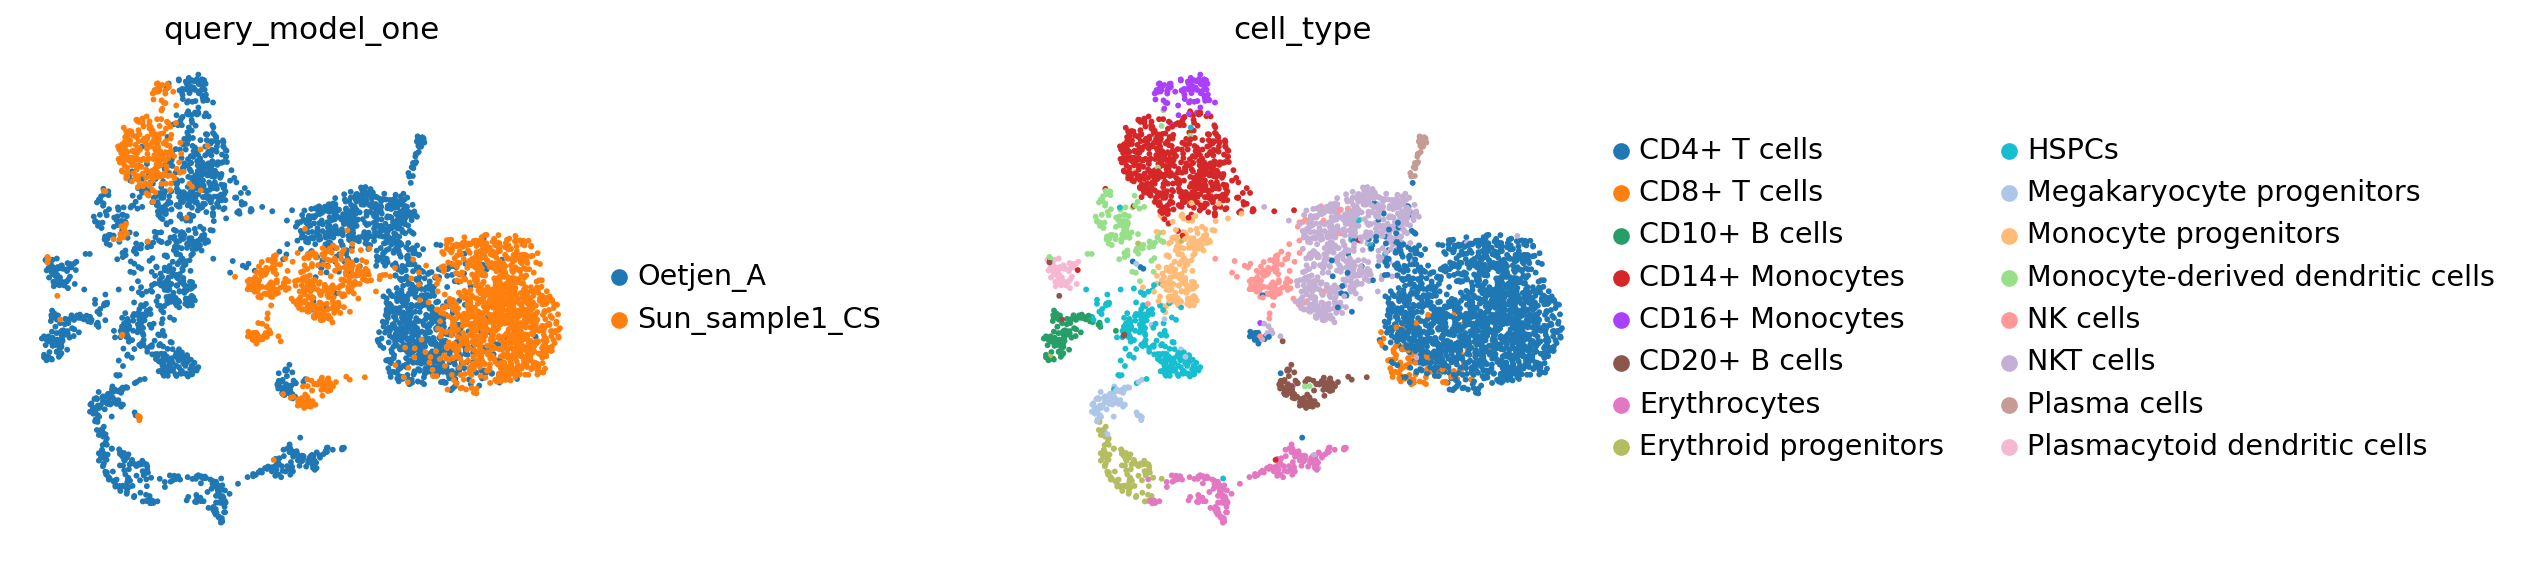

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


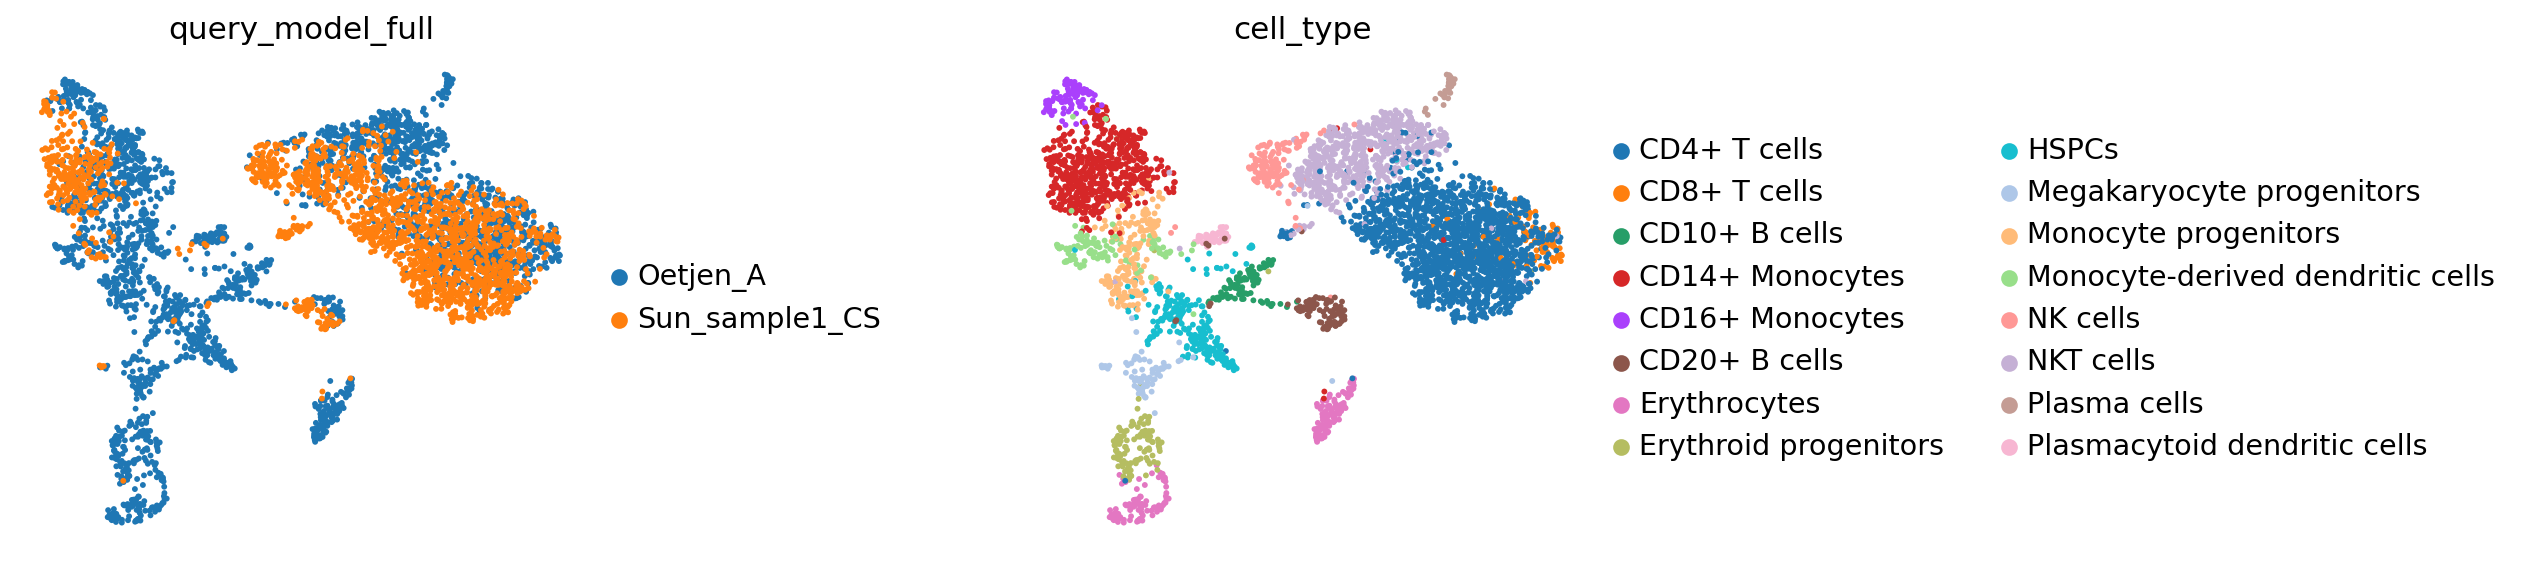

In [84]:
for i in range(len(adata_latent_array)):
    sc.pp.neighbors(adata_latent_array[i], n_neighbors=8)
    sc.tl.leiden(adata_latent_array[i])
    sc.tl.umap(adata_latent_array[i])
    sc.pl.umap(adata_latent_array[i],
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )

In [85]:
for j in range(len(models)):
    models[j].save(surg_path[j], overwrite=True)

### Get latent representation of reference + query dataset and compute UMAP

In [86]:
adata = adata[:, source_adata.var_names]
adata

View of AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [87]:
full_latent_array = []

In [88]:
adata.obs['ref_or_query'] = np.where(adata.obs['batch'].isin(target_conditions), 'query', 'ref')

In [89]:
for model in models:
    full_latent = sc.AnnData(model.get_latent(adata.X, adata.obs['batch']))
    full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
    full_latent.obs['batch'] = adata.obs[condition_key].tolist()
    full_latent.obs['ref_or_query'] = adata.obs['ref_or_query'].tolist()
    full_latent_array.append(full_latent)

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


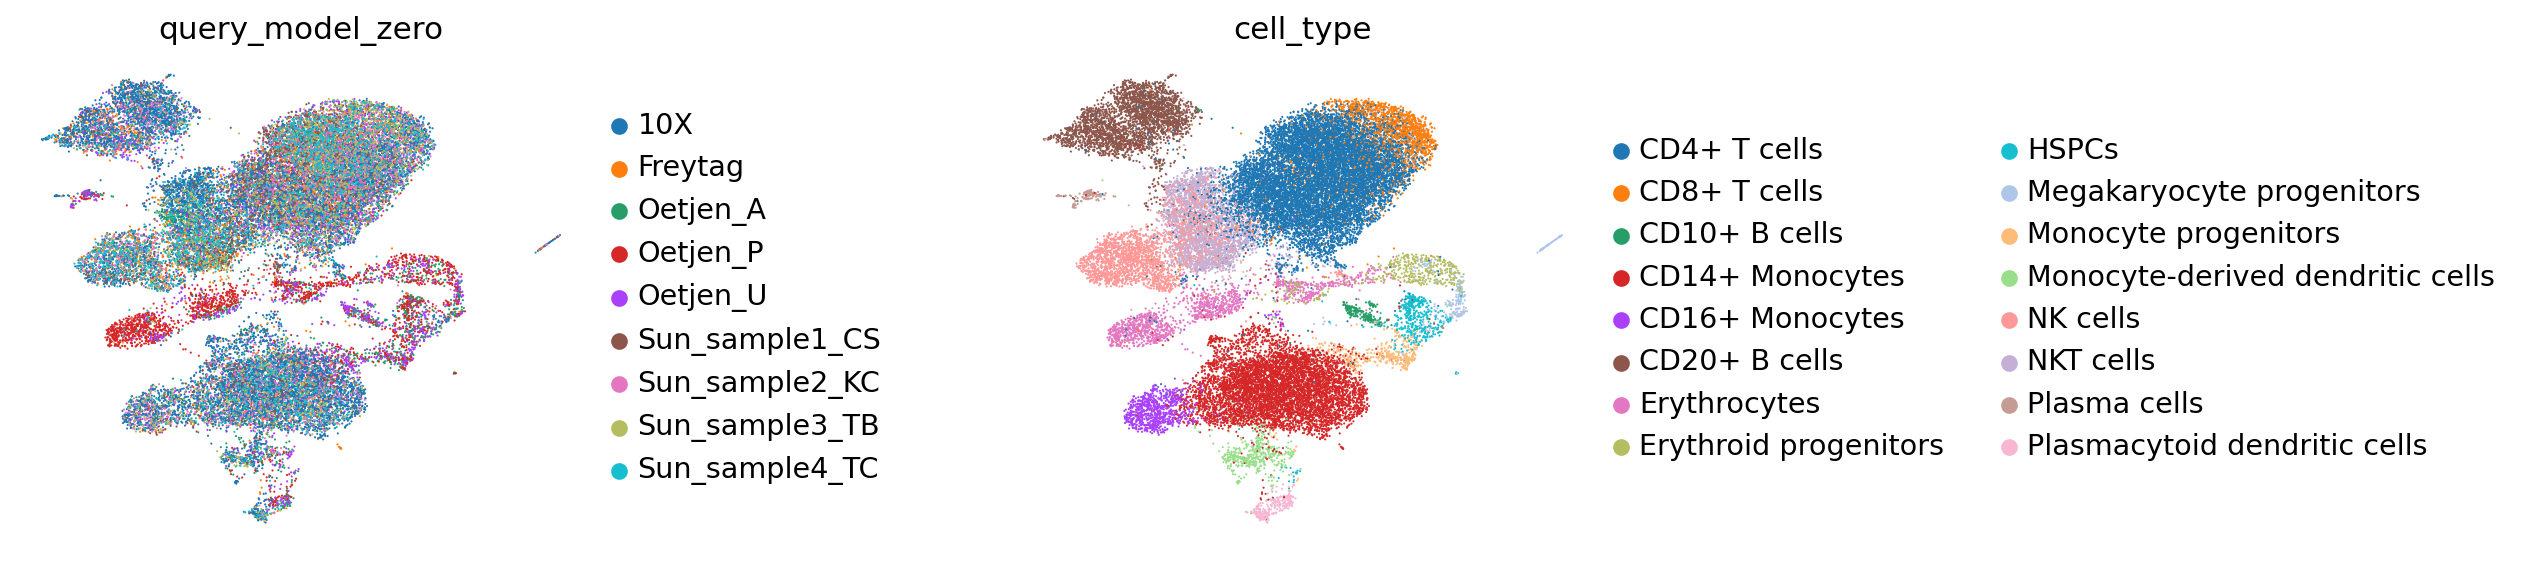

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


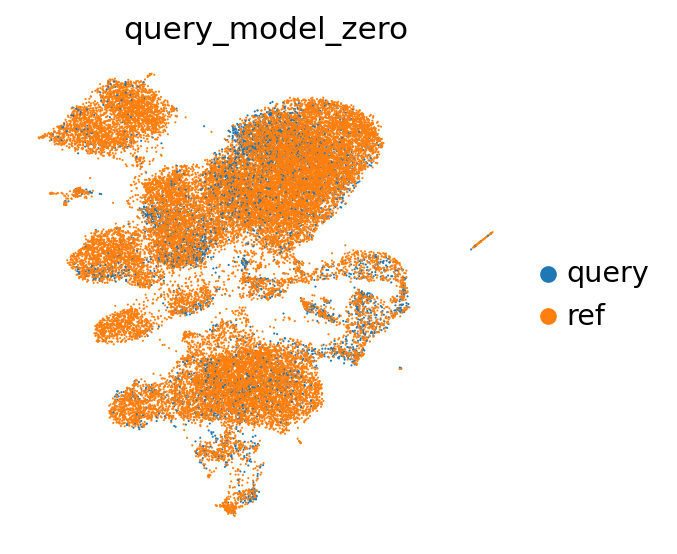

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


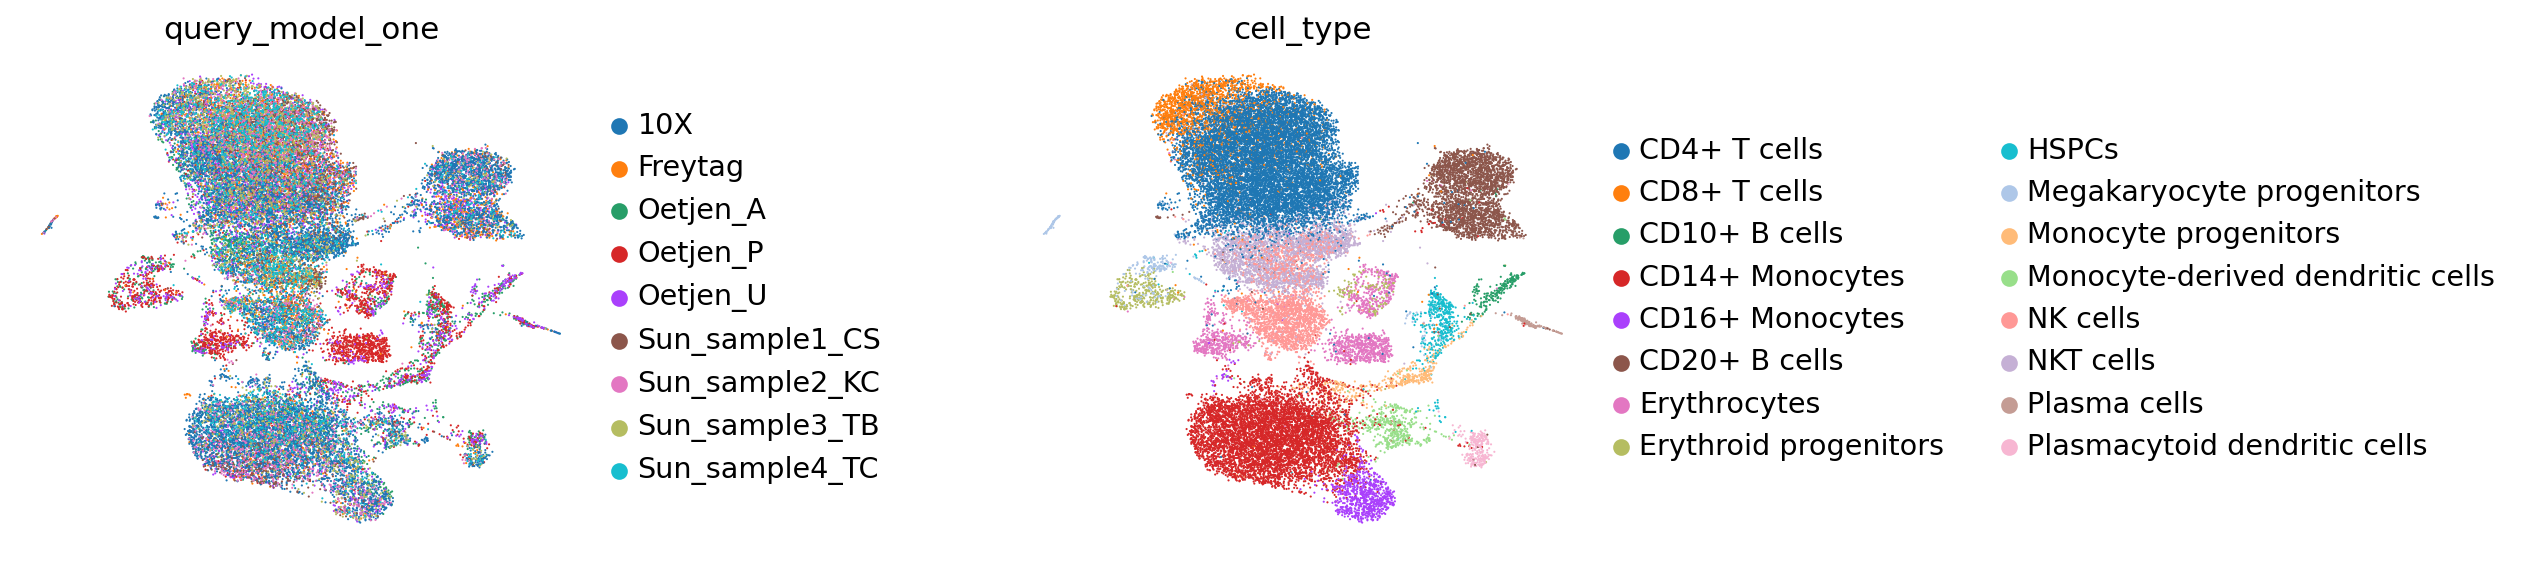

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


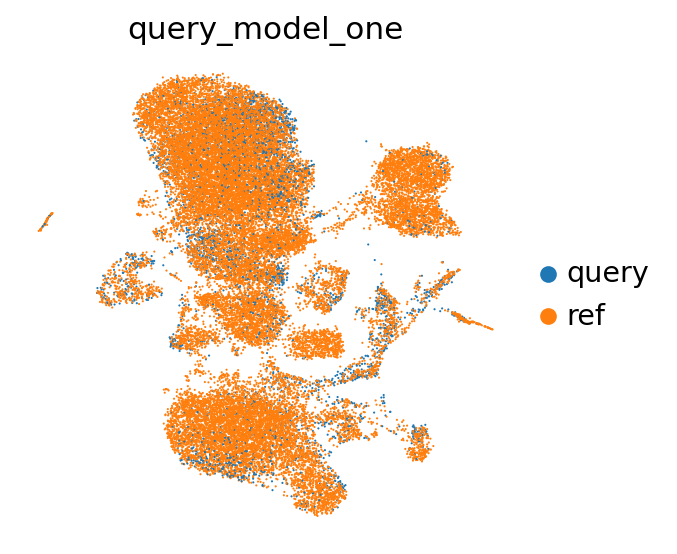

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


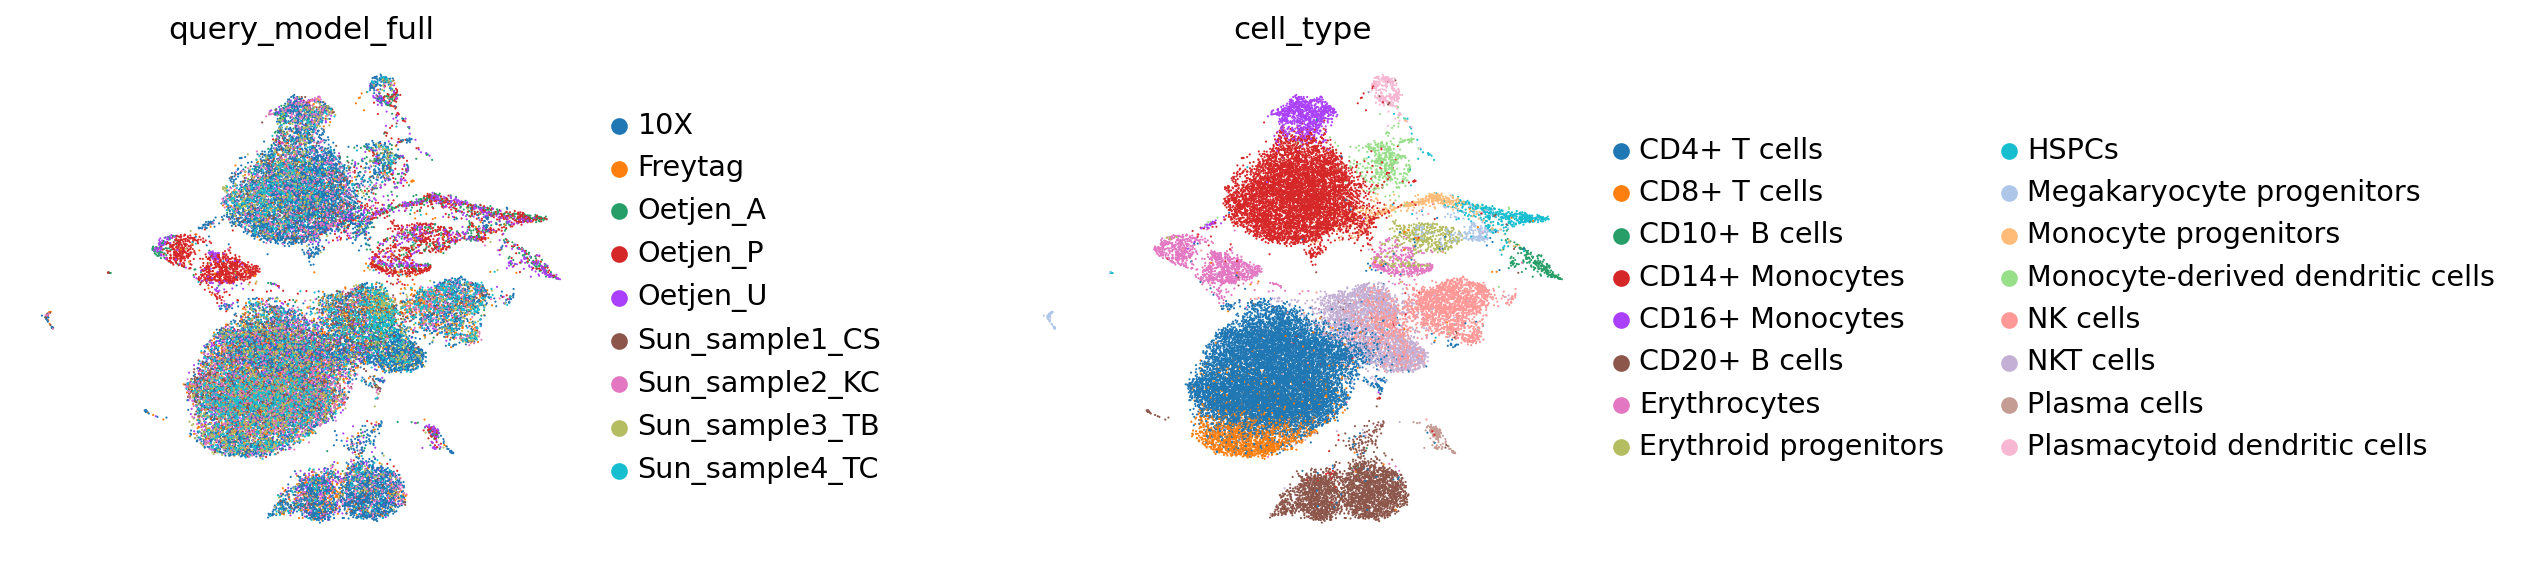

/home/icb/aleksandra.topalova/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


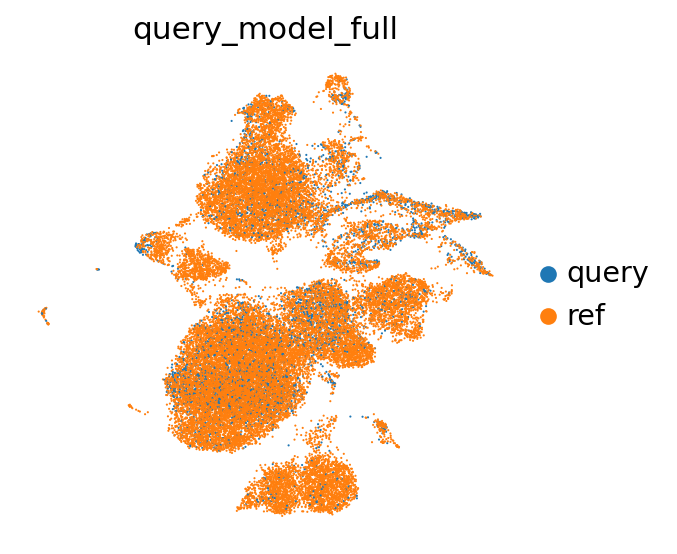

In [90]:
for i in range(len(full_latent_array)):
    sc.pp.neighbors(full_latent_array[i], n_neighbors=8)
    sc.tl.leiden(full_latent_array[i])
    sc.tl.umap(full_latent_array[i])
    sc.pl.umap(full_latent_array[i],
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )
    sc.pl.umap(full_latent_array[i],
           color=['ref_or_query'],
           frameon=False,
           wspace=0.6,
           title = surg_path[i]
           )

## Benchmarking for Biological Conservation and Batch Correction

In [91]:
results_array = []

In [92]:
full_latent_array

[AnnData object with n_obs × n_vars = 32484 × 10
     obs: 'cell_type', 'batch', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 32484 × 10
     obs: 'cell_type', 'batch', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 32484 × 10
     obs: 'cell_type', 'batch', 'ref_or_query', 'leiden'
     uns: 'neighbors', 'leiden', 'umap', 'batch_colors', 'cell_type_colors', 'ref_or_query_colors'
     obsm: 'X_umap'
     obsp: 'distances', 'connectivities']

In [93]:
adata.obs['cell_type'] = adata.obs['final_annotation']

In [94]:
for i in range(len(full_latent_array)):
    results = scib.metrics.metrics(
        adata, full_latent_array[i],
        batch_key= 'batch',label_key = 'cell_type', organism= 'human', subsample=1., embed = 'X_umap',
        graph_conn_=True, nmi_ = True, ari_ = True,
        ilisi_=False, isolated_labels_asw_= True, cell_cycle_= True,
        silhouette_=True
    )
    results_array.append(results)

NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...
NMI...
ARI...
Silhouette score...
cell cycle effect...
Isolated labels ASW...
Graph connectivity...


In [95]:
def median_bio_conserv(results):
    column = results[0]
    return (column.iloc[0] + column.iloc[1] + column.iloc[2] + column.iloc[4])/4

In [96]:
def median_batch_corr(results):
    column = results[0]
    return (column.iloc[3] + column.iloc[5] + column.iloc[6])/3

# Results

In [97]:
results_zero = results_array[0].dropna()


In [98]:
print('Zero shot: ')
print(f"bio_conservation = {median_bio_conserv(results=results_zero)}")
print(f"batch_correction = {median_batch_corr(results=results_zero)}")
results_zero

Zero shot: 
bio_conservation = 0.5944031574752814
batch_correction = 0.7369846849947632


0
NMI_cluster/label          0.759639
ARI_cluster/label          0.726700
ASW_label                  0.584329
ASW_label/batch            0.746048
cell_cycle_conservation    0.306945
isolated_label_silhouette  0.500663
graph_conn                 0.964243

In [99]:
results_one = results_array[1].dropna()

In [100]:
print('One shot: ')
print(f"bio_conservation = {median_bio_conserv(results=results_one)}")
print(f"batch_correction = {median_batch_corr(results=results_one)}")
results_one

One shot: 
batch_correction = 0.5871239285742664
batch_correction = 0.7296135771599643


0
NMI_cluster/label          0.762134
ARI_cluster/label          0.766847
ASW_label                  0.597208
ASW_label/batch            0.731013
cell_cycle_conservation    0.222306
isolated_label_silhouette  0.508459
graph_conn                 0.949369

In [101]:
results_full = results_array[2].dropna()

In [102]:
print('Full query: ')
print(f"bio_conservation = {median_bio_conserv(results=results_full)}")
print(f"batch_correction = {median_batch_corr(results=results_full)}")
results_full

Full query: 
bio_conservation = 0.592267294276072
batch_correction = 0.7459458382906075


0
NMI_cluster/label          0.766754
ARI_cluster/label          0.741178
ASW_label                  0.599454
ASW_label/batch            0.756491
cell_cycle_conservation    0.261683
isolated_label_silhouette  0.532170
graph_conn                 0.949177